# Proccessing, analysis, and visualization pipeline for electrophysiology multi-unit-activity data aligned to a large sample of single, brief events (i.e. stimulation pulses)

## The goal of this pipeline is to create group-level peri-event binned histograms for data from 2 groups (experimental and control)

## Designed for data batch pre-processed in Neuroexplorer using the "Striatum-Pulse_Final.py" script to apply the "BLPulses_50ms.ntp" template to raw data 

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn
import os
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
from pandas import DataFrame, date_range, datetime, read_csv
from matplotlib import pyplot, colors, rcParams 
from datetime import timedelta  
from numpy import NaN, asarray
from math import isnan
import seaborn as sns

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# Plotting helper function

In [9]:
def haxes(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
        label_size=None, tick_size=None, title=None, title_size=None, x_ticks = 100, y_ticks = 11, color = 'black',
        numfty = numfmt, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
          
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)
        tlen = int(tick_size/5)
        
        axes.tick_params(axis = 'both', which = 'major', labelsize=tick_size, direction='out', top='off', right='off',
                         width = 5, length = tlen)
        
        axes.tick_params(axis = 'x', which = 'minor', labelsize=tick_size, direction='out', top='off', right='off', left= 'off',
                         width = 5, length = tlen/1.5)
        
        axes.set_xlim(right = df.shape[0])
        
        axes.yaxis.set_major_locator(ticker.MultipleLocator(y_ticks))
        axes.xaxis.set_major_locator(ticker.MultipleLocator(x_ticks))
        
        axes.xaxis.set_minor_locator(ticker.MultipleLocator(x_ticks/5))
        
        axes.xaxis.set_major_formatter(FuncFormatter(numfmtx))
        axes.yaxis.set_major_formatter(FuncFormatter(numfty))
        
        dfe = df.sem(axis=1)
        dfm = df.mean(axis=1)
        dfi= range(0,len(dfm),1)

        bars = axes.bar(dfi, dfm, bottom=None, yerr = dfe, ecolor = color, align='center', width=1,
                        color=color, edgecolor = color, error_kw=dict(elinewidth=3.25, alpha= .3), **kwargs)

        return fig, axes

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [ ]:
prj = pn.Project('/project-folder-path') # load project object
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object, and to baseline subtract to get the change in firing rate using dummy events from a corresponding time-shifted period outside of event blocks

In [3]:
#set epoch start (es) and eposh end (ee) to fit the time window you want to use for plotting
#note that in this example, the data coming into the pipeline is aligned to a stimulation that begins at 250
def get_data(prj, group, cond):
    new_prj = prj(2, 'subproject-folder-name', group, cond, ext='.xlsx')
    es = 249
    ee = 500
    df = pd.DataFrame()
    for f, finfo in new_prj:
        dft = pd.DataFrame()
        dff = pd.read_excel(finfo.Abspath, index_col = None).dropna()
        chunk_size = int(dff.shape[1] / 2)
        
        for col in range(0, chunk_size, 1):
            bloff = col+chunk_size
            dft[col] = (dff.iloc[es:ee,bloff] - np.mean(dff.iloc[es:ee,col]))
        df = pd.concat([df, dft], axis=1, ignore_index=True)
        
    print cond + "events: " + df.shape[1]
    return df

# Functions to convert axis units
## first 2 are default x axis and y axis major tick mark formats

In [8]:
def numfmtx(x, pos): # custom formatter function
    t = '{:.0f}'.format((x)/10)
    return t

In [5]:
def numfmt(y, pos): # custom formatter function
    s = '{:.1f}'.format(y*100)
    return s

## Second 2 are for first (experimental) and second (control) condition plots (if plotted separately), respectively.
## when plotted together the plot uses the first formatter only



In [6]:
def numfmt0(y, pos): # custom formatter function
    s = '{:.0f}'.format(y*100)
    return s

In [7]:
def numfmt2(y, pos): # custom formatter function
    s = '{:.2f}'.format(y*100)
    return s

# Peri-event histogram plotting function for 2 conditions (experimental and control)
## plots 4 versions to help visualize data with different scales. Grouped data is sent to Excel

In [10]:
def plot_data(prj, group, Cxls= None, Exls= None, first_cond = 'ChR2', second_cond = 'eYFP', figsize=[7.5,7.5], label_size=60, title_size=60, ylim = [-5,15],
              tick_size=50, ylabel='Spike chance (%)', xlabel='Time (ms)', y_ticks = 1, x_ticks = 50,
              linewidth = 5, y_tickse = 1, ylime = [-5,15], stim=[[50],100], numfmt = numfmt0, enumfmt = numfmt2):
                    
    if Cxls:
        data_ChR2=pd.ExcelFile(Cxls)
        data_ChR2=pd.ExcelFile.parse(data_ChR2, header = None, index_col = None)

    else:
        data_ChR2 = get_data(prj, group, first_cond)
        data_ChR2=data_ChR2.reset_index(drop = True)
        data_ChR2.to_excel('{}_{}.xlsx'.format(group, first_cond), index = None, header = None)
    if Exls:
        data_eYFP=pd.ExcelFile(Exls)
        data_eYFP=pd.ExcelFile.parse(data_eYFP, header = None, index_col = None)

    else:
        data_eYFP = get_data(prj, group, second_cond)

        data_eYFP.to_excel('{}_{}.xlsx'.format(group, second_cond), index = None, header = None)
      
    a1 = haxes(data_ChR2, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
                 ylabel= ylabel, xlabel=xlabel, y_ticks = y_ticks, x_ticks = x_ticks, ylim = ylim, color = 'tab:red',
              numfty = numfmt)
    
    ylim_neg1 = a1[1].get_ylim()
    if stim:
        for p in stim[0]:
            a1[1].add_patch(patches.Rectangle((p, ylim_neg1[0]), stim[1], abs(ylim_neg1[0])+abs(ylim_neg1[1]),color='g', alpha=0.09))

    a2 = haxes(data_eYFP, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
                 ylabel= ylabel, xlabel=xlabel, y_ticks = y_ticks, x_ticks = x_ticks, ylim = ylim, color = 'tab:grey',
              numfty = numfmt)

    ylim_neg2 = a2[1].get_ylim()
    if stim:
        for p in stim[0]:
            a2[1].add_patch(patches.Rectangle((p, ylim_neg2[0]), stim[1], abs(ylim_neg2[0])+abs(ylim_neg2[1]),color='g', alpha=0.09))

    a3 = haxes(data_ChR2, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
                 ylabel= ylabel, xlabel=xlabel, y_ticks = y_ticks, x_ticks = x_ticks, ylim = ylim, color = 'tab:red',
              numfty = numfmt)
    
    
    a3 = haxes(data_eYFP, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
                 ylabel= ylabel, xlabel=xlabel, y_ticks = y_ticks, x_ticks = x_ticks, ylim = ylim, color = 'tab:grey',
               numfty = numfmt, add_plot = a3)        
    
    ylim_neg3 = a3[1].get_ylim()
    if stim:
        for p in stim[0]:
            a3[1].add_patch(patches.Rectangle((p, ylim_neg3[0]), stim[1], abs(ylim_neg3[0])+abs(ylim_neg3[1]),color='g', alpha=0.09))
   
    a4 = haxes(data_eYFP, figsize=figsize,label_size=label_size, title_size=title_size, tick_size=tick_size,
               ylabel= ylabel, xlabel=xlabel, y_ticks = y_tickse, x_ticks = x_ticks, ylim = ylime,
               color = 'tab:grey', numfty = enumfmt)

    ylim_neg4 = a4[1].get_ylim()
    if stim:
        for p in stim[0]:
            a4[1].add_patch(patches.Rectangle((p, ylim_neg4[0]), stim[1], abs(ylim_neg4[0])+abs(ylim_neg4[1]),color='g', alpha=0.09))

    return a1, a2, a3, a4

575
520


((<matplotlib.figure.Figure at 0x7fc4b8cb5250>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc4b0af4590>),
 (<matplotlib.figure.Figure at 0x7fc4b8aac450>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc4b84a13d0>),
 (<matplotlib.figure.Figure at 0x7fc4b8285dd0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc4a81a5b50>),
 (<matplotlib.figure.Figure at 0x7fc4c01a6750>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fc4c082ba10>))

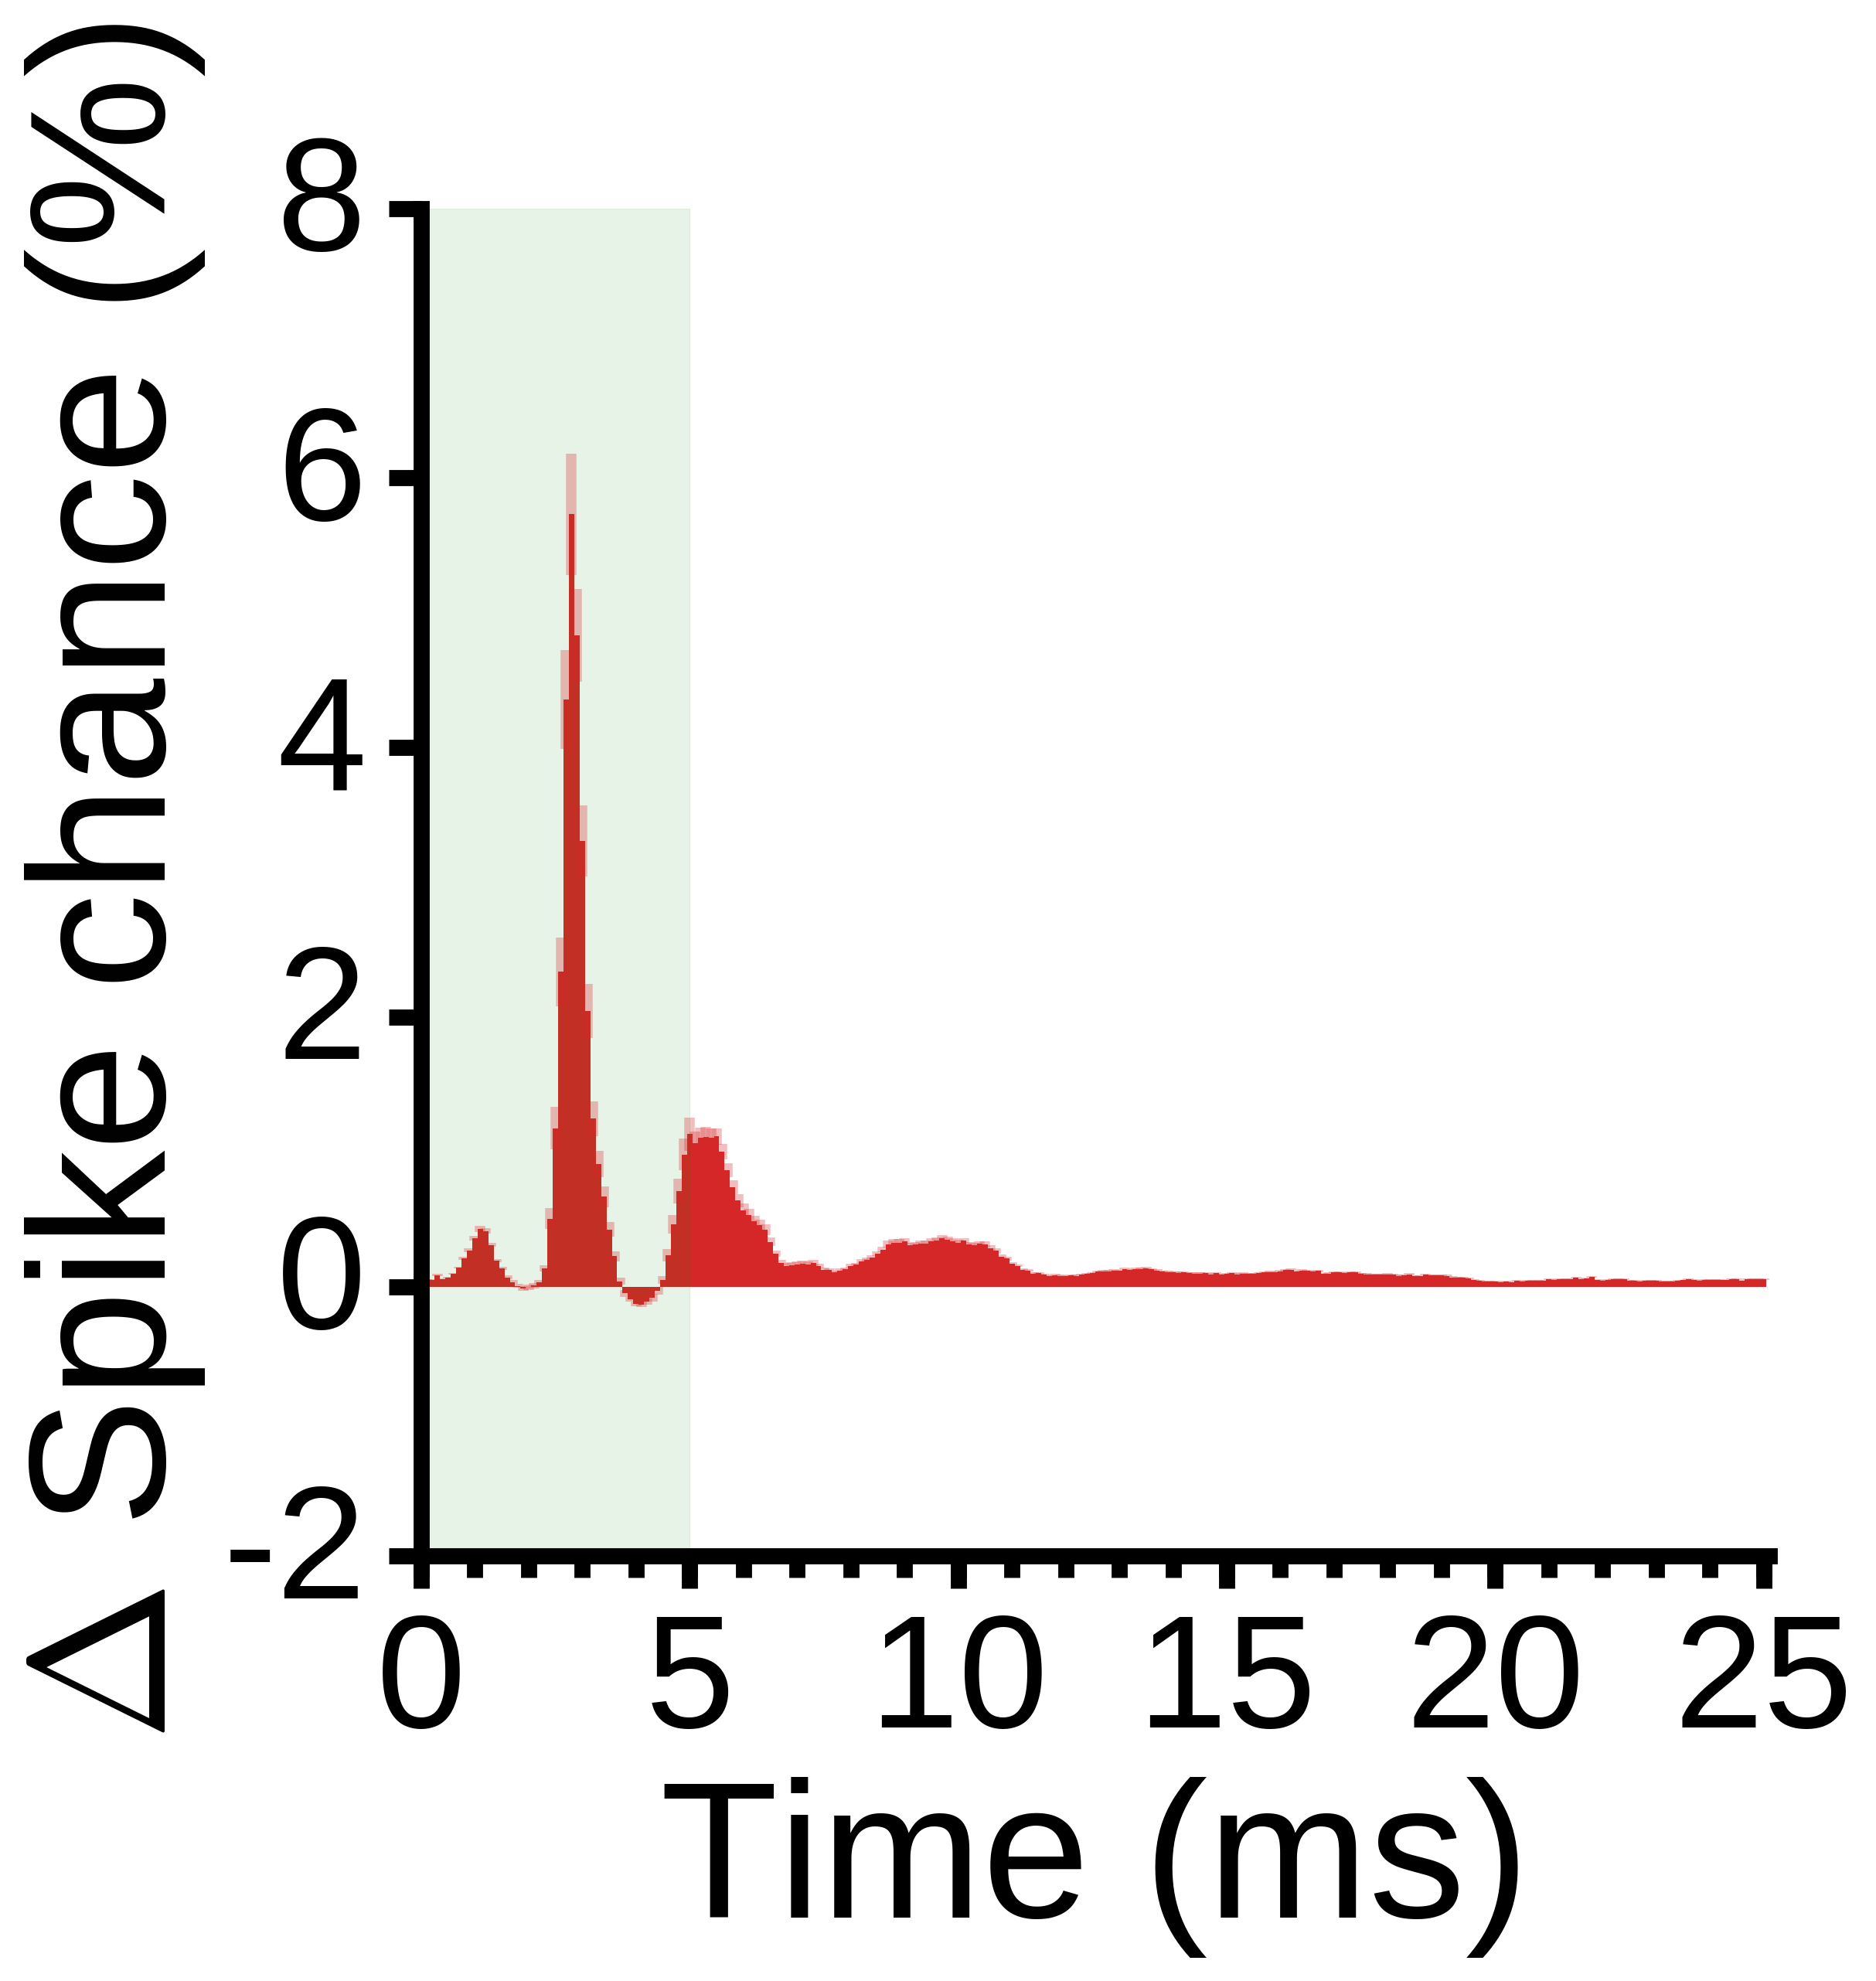

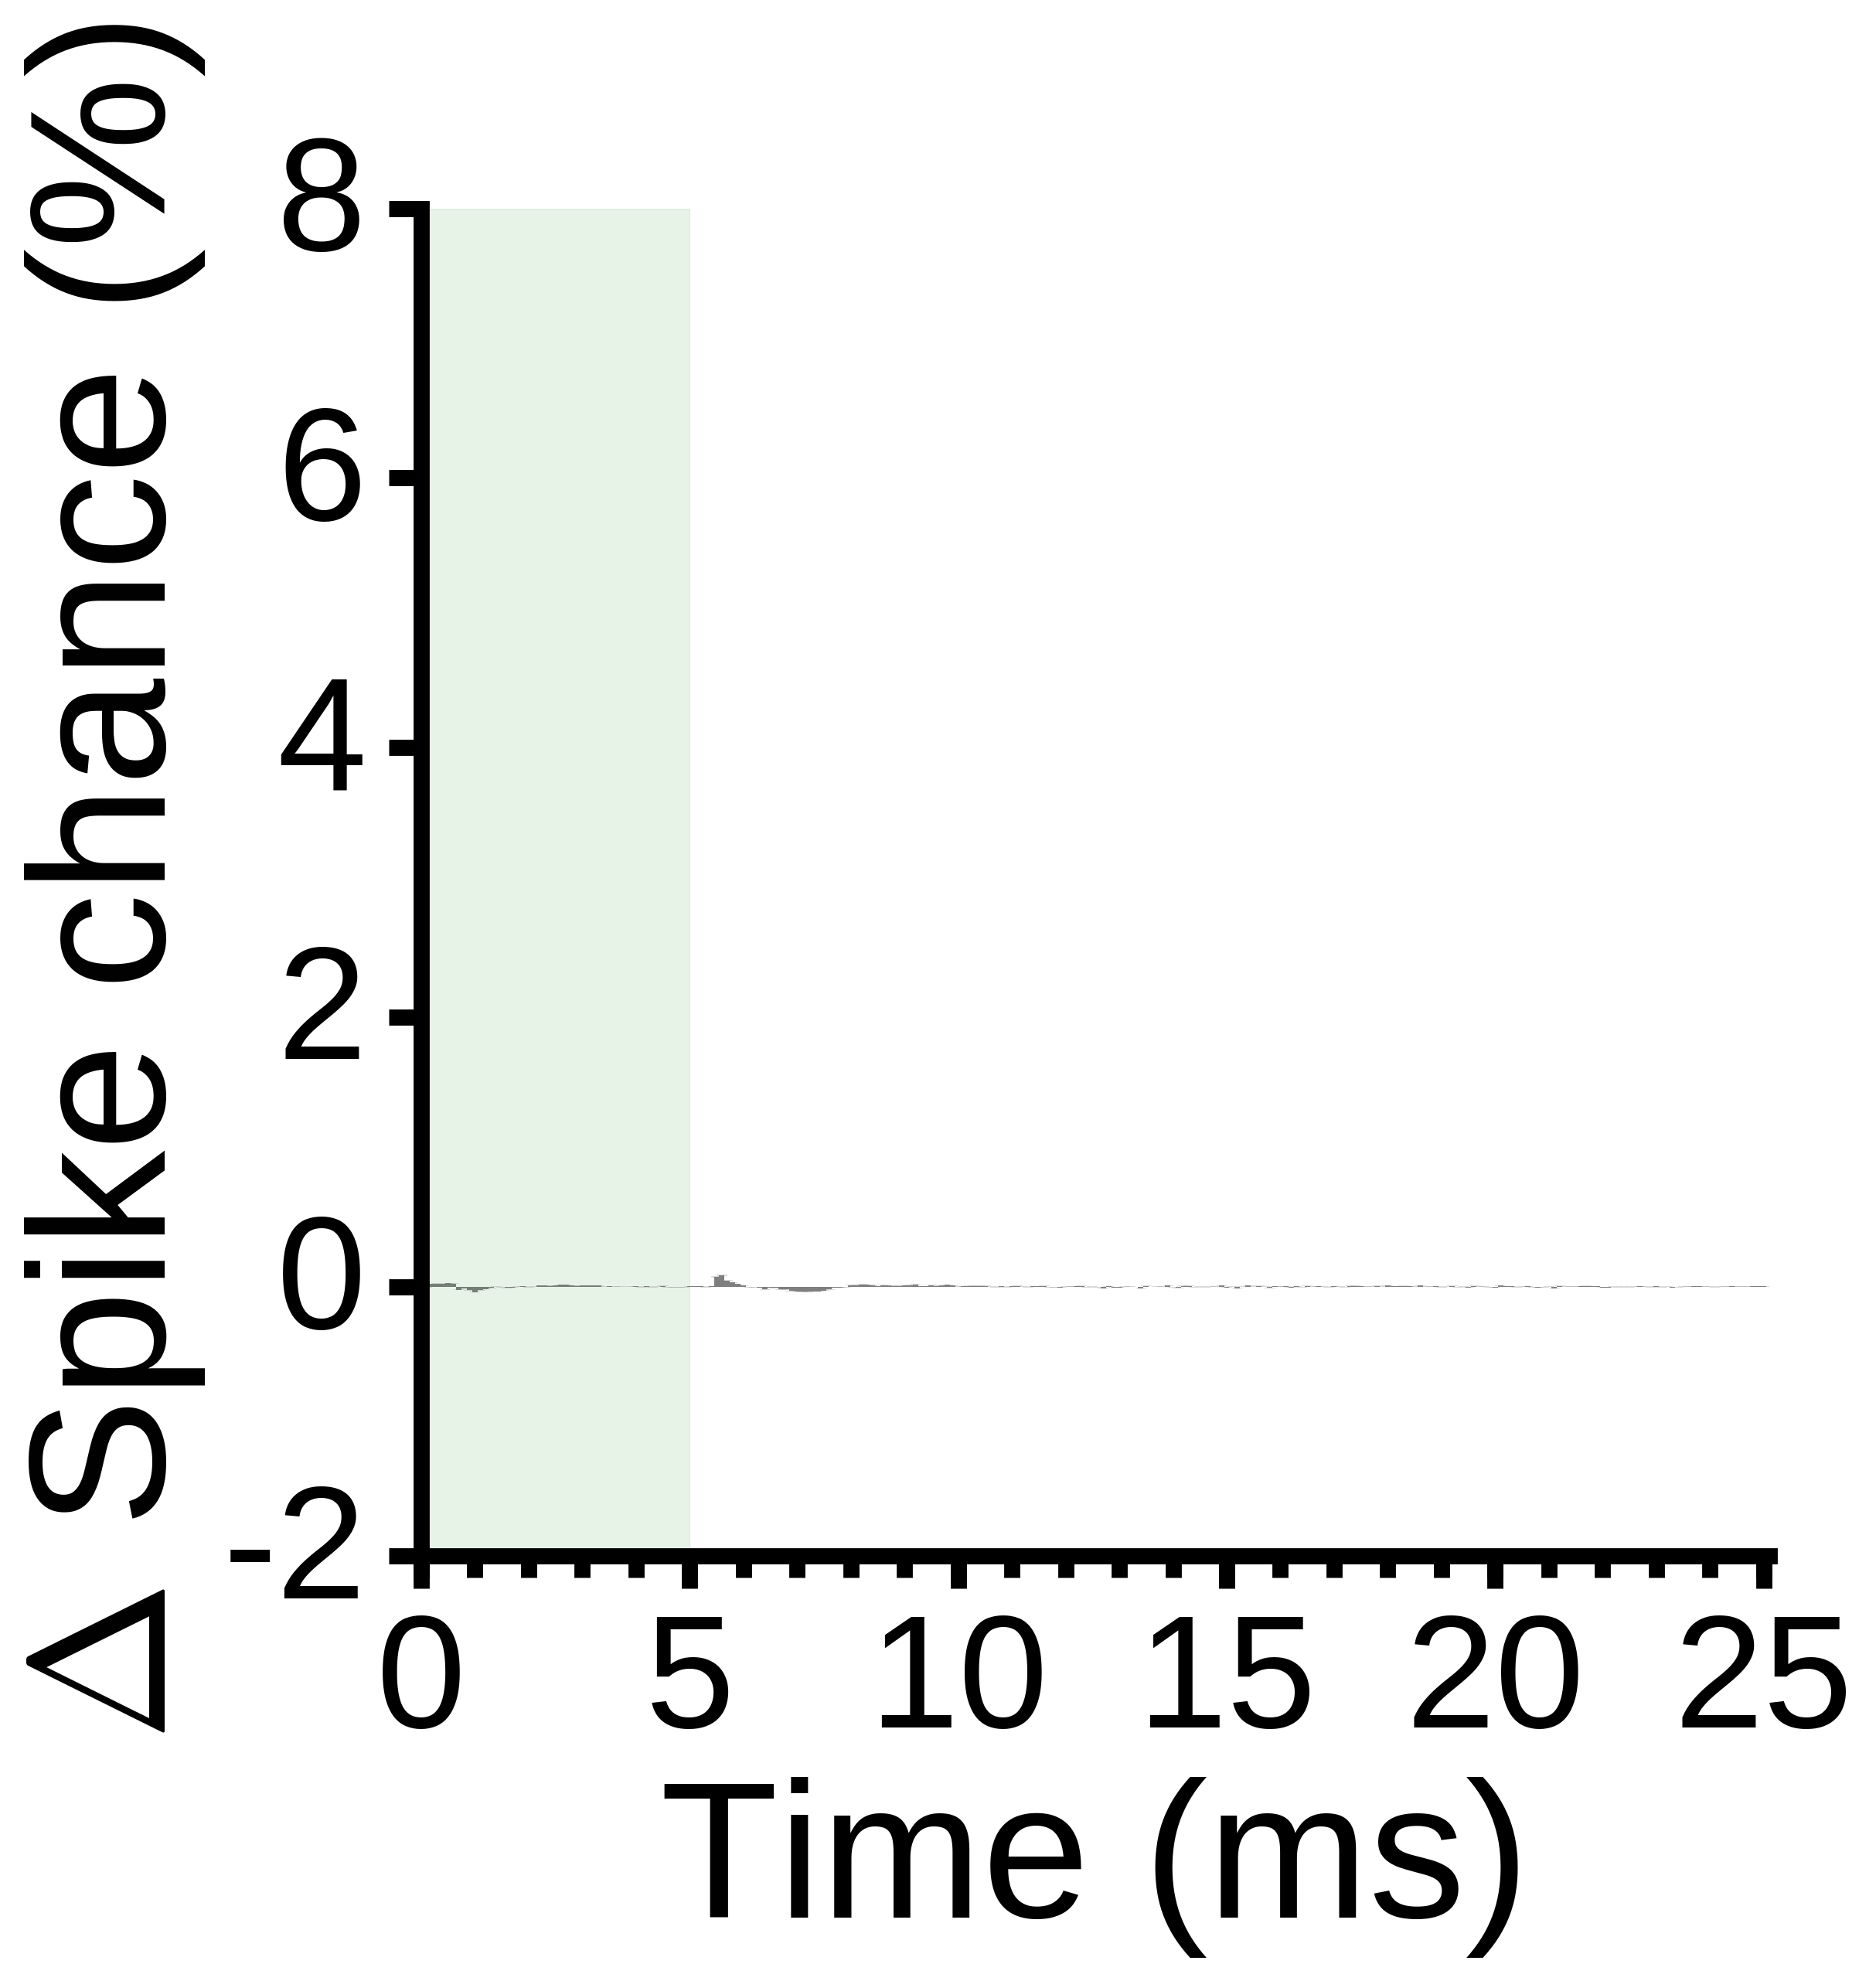

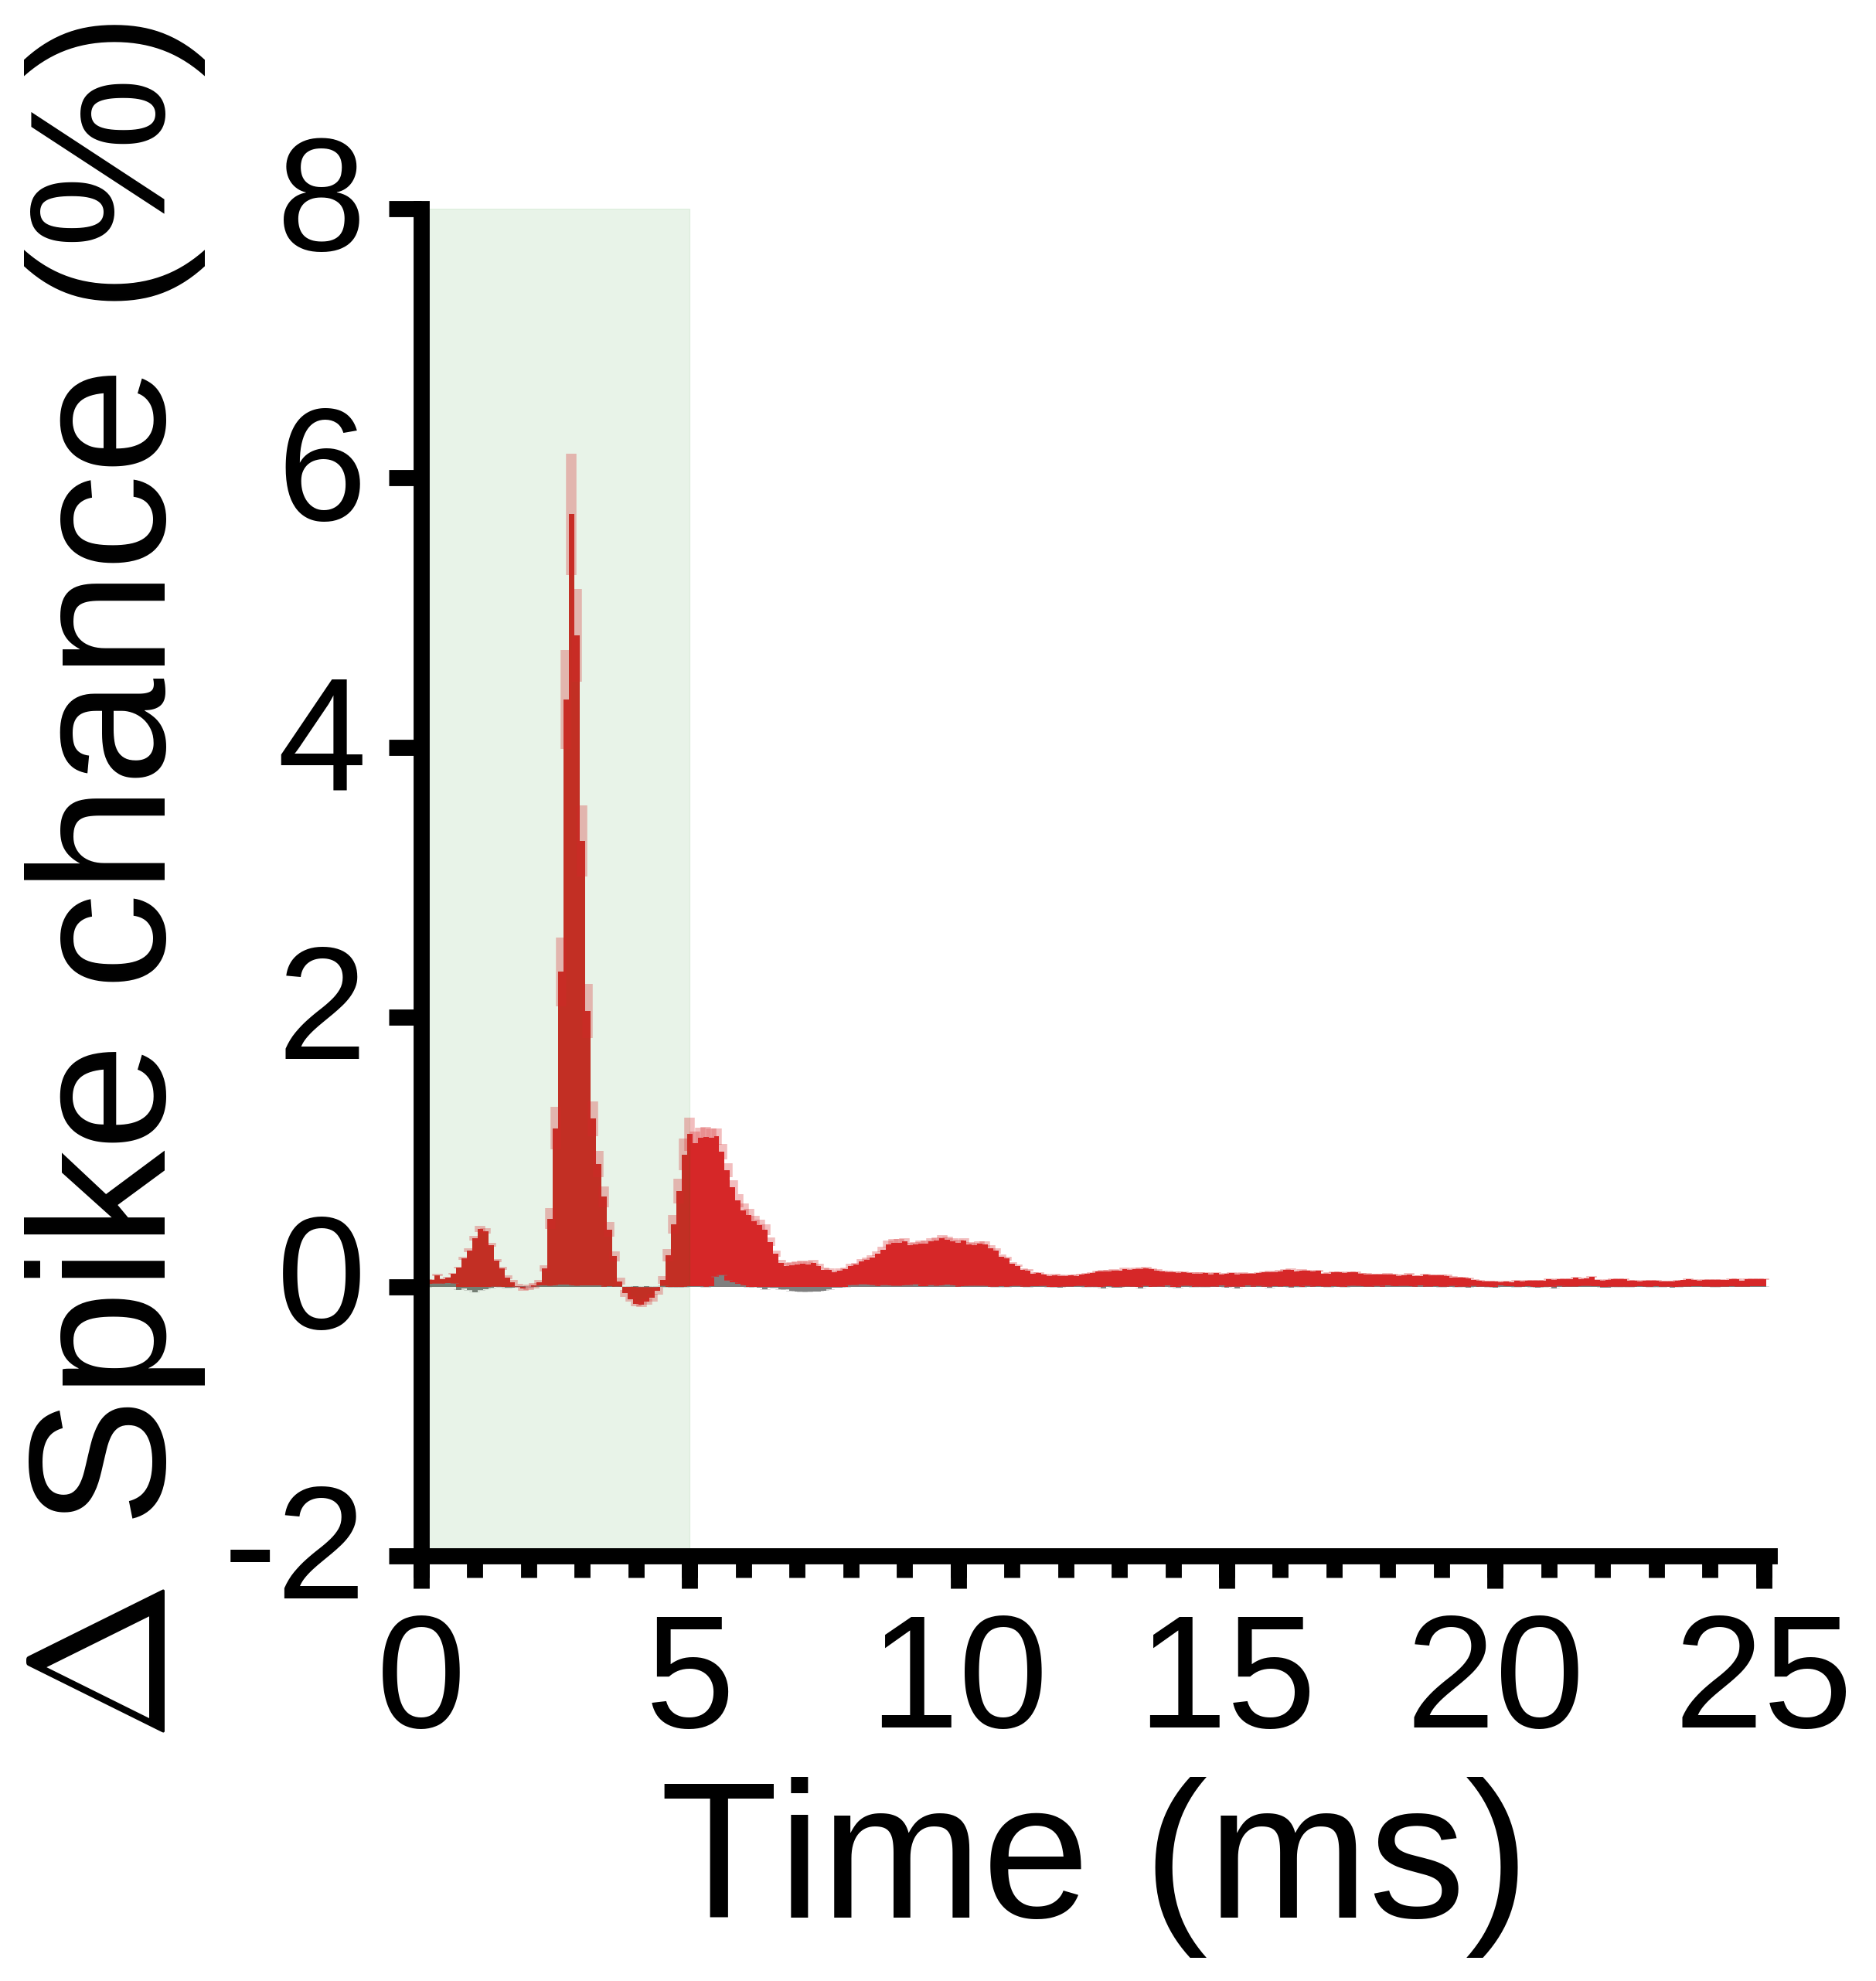

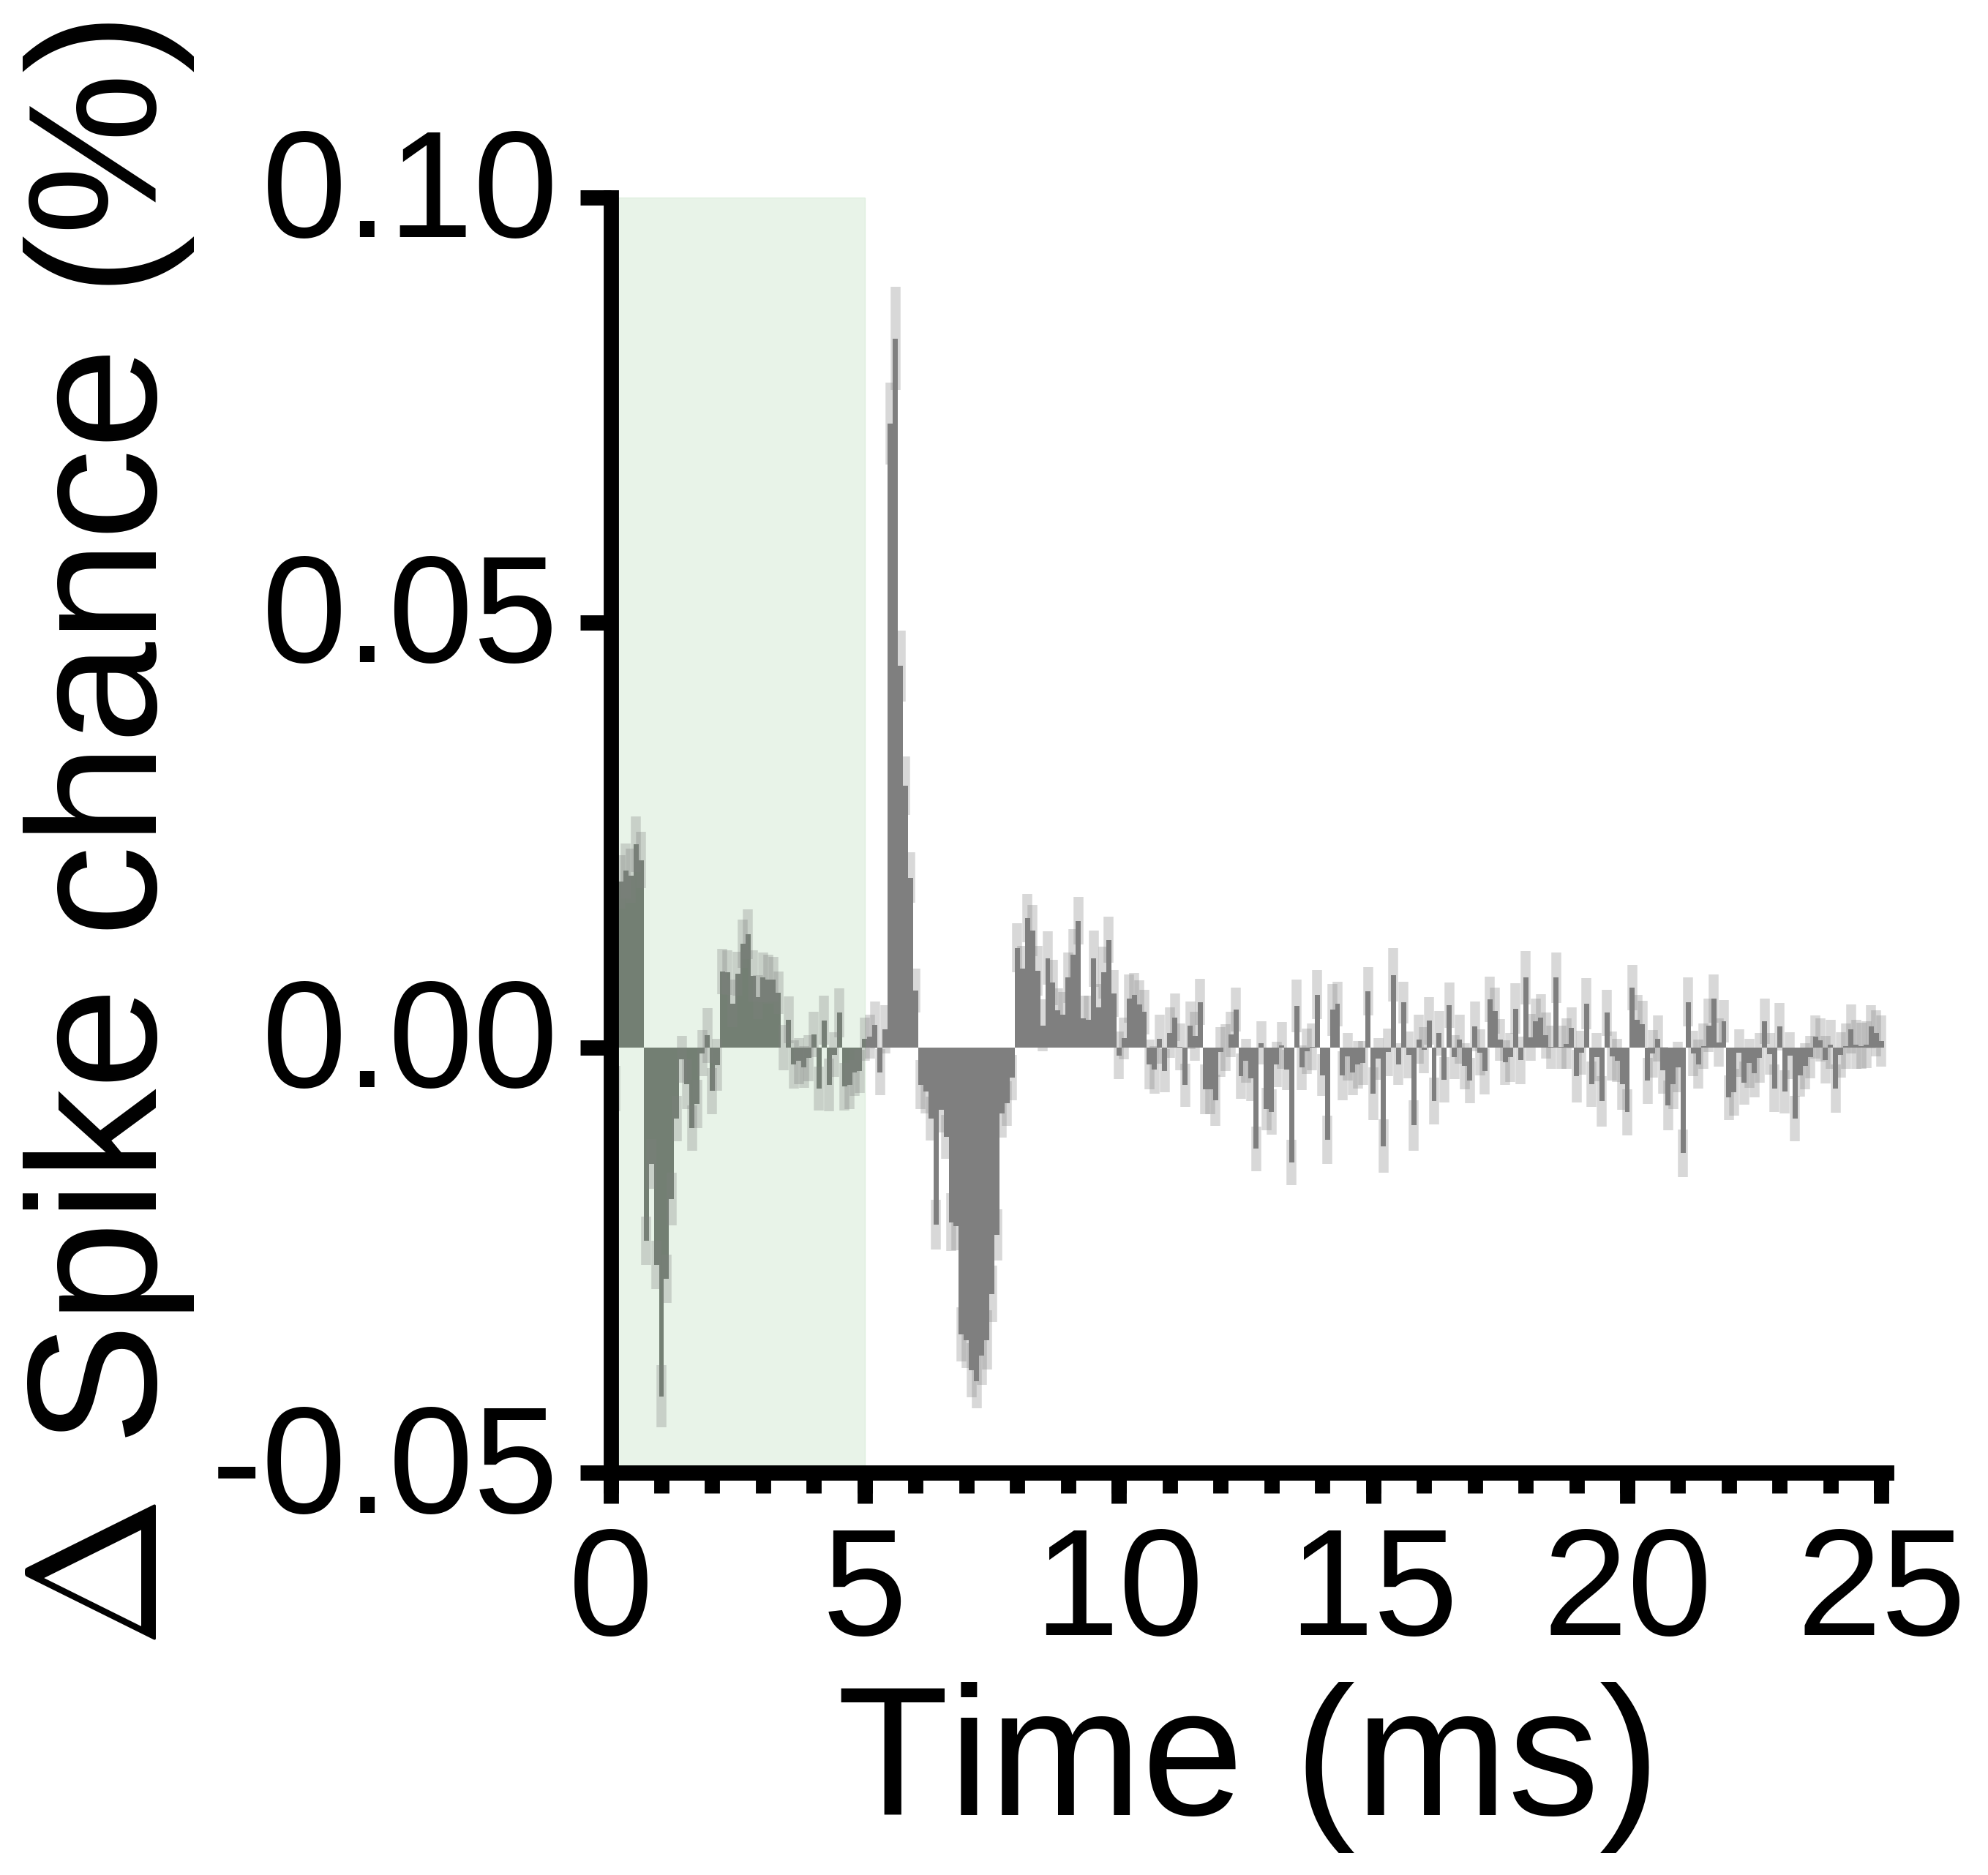

In [14]:
plot_data(prj, 'group-folder-name',
#           Cxls ='experimental-cond-name.xlsx',Exls ='control-cond-name.xlsx', #point these to the groupxcondition level Excel files from prior analyses to just plot the data
          x_ticks = 50, y_ticks = .02, ylim = [-.02,.08], y_tickse = .0005, ylime = [-.0005,.001], stim=[[0],50],
          ylabel = r'$\Delta$'+" Spike chance (%)", numfmt = numfmt0, enumfmt = numfmt2)